## Install dependencies

## Load CodeXGLUE Database for Defect detect

In [1]:
# Imports
import pandas as pd
from datasets import load_dataset

# Load dataset
ds = load_dataset("google/code_x_glue_cc_defect_detection")

# Convert to pandas for exploration
train_df = pd.DataFrame(ds["train"])
val_df = pd.DataFrame(ds["validation"])
test_df = pd.DataFrame(ds["test"])


## Data Exploration and Data Analysis
using pandas and matplotlib

In [2]:
# Quick look
print(train_df.head())
print(train_df.columns)
print(train_df["target"].value_counts(normalize=True))  # class balance


   id                                               func  target project  \
0   0  static av_cold int vdadec_init(AVCodecContext ...   False  FFmpeg   
1   1  static int transcode(AVFormatContext **output_...   False  FFmpeg   
2   2  static void v4l2_free_buffer(void *opaque, uin...   False  FFmpeg   
3   4  int av_opencl_buffer_write(cl_mem dst_cl_buf, ...   False  FFmpeg   
4   5  static int r3d_read_rdvo(AVFormatContext *s, A...    True  FFmpeg   

                                  commit_id  
0  973b1a6b9070e2bf17d17568cbaf4043ce931f51  
1  321b2a9ded0468670b7678b7c098886930ae16b2  
2  5d5de3eba4c7890c2e8077f5b4ae569671d11cf8  
3  57d77b3963ce1023eaf5ada8cba58b9379405cc8  
4  aba232cfa9b193604ed98f3fa505378d006b1b3b  
Index(['id', 'func', 'target', 'project', 'commit_id'], dtype='object')
target
False    0.541594
True     0.458406
Name: proportion, dtype: float64


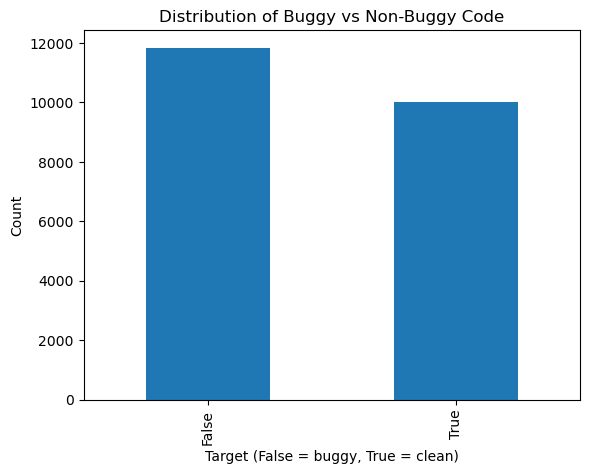

In [3]:
import matplotlib.pyplot as plt

train_df["target"].value_counts().plot(
    kind="bar", 
    title="Distribution of Buggy vs Non-Buggy Code",
    xlabel="Target (False = buggy, True = clean)",
    ylabel="Count"
)
plt.show()


In [4]:
print("Example 1")
print(train_df.iloc[0]["func"])
print("Buggy:", train_df.iloc[0]["target"])


Example 1
static av_cold int vdadec_init(AVCodecContext *avctx)

{

    VDADecoderContext *ctx = avctx->priv_data;

    struct vda_context *vda_ctx = &ctx->vda_ctx;

    OSStatus status;

    int ret;



    ctx->h264_initialized = 0;



    /* init pix_fmts of codec */

    if (!ff_h264_vda_decoder.pix_fmts) {

        if (kCFCoreFoundationVersionNumber < kCFCoreFoundationVersionNumber10_7)

            ff_h264_vda_decoder.pix_fmts = vda_pixfmts_prior_10_7;

        else

            ff_h264_vda_decoder.pix_fmts = vda_pixfmts;

    }



    /* init vda */

    memset(vda_ctx, 0, sizeof(struct vda_context));

    vda_ctx->width = avctx->width;

    vda_ctx->height = avctx->height;

    vda_ctx->format = 'avc1';

    vda_ctx->use_sync_decoding = 1;

    vda_ctx->use_ref_buffer = 1;

    ctx->pix_fmt = avctx->get_format(avctx, avctx->codec->pix_fmts);

    switch (ctx->pix_fmt) {

    case AV_PIX_FMT_UYVY422:

        vda_ctx->cv_pix_fmt_type = '2vuy';

        break;

    case AV_PIX_FM

## Convert Dataset
converting the pandas dataframe to a huggingface dataset for training 

In [5]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

print(type(train_ds))  # should be <class 'datasets.arrow_dataset.Dataset'>

<class 'datasets.arrow_dataset.Dataset'>


## Tokenize Code

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

def tokenize_and_prepare_labels(example):
    # Tokenize the code snippet
    tokens = tokenizer(
        example["func"],           # change 'code' if your column is named differently
        padding="max_length",
        truncation=True,
        max_length=256
    )
    # Convert True/False to integer labels
    tokens["labels"] = int(example["target"])  # change 'target' if your label column is named differently
    return tokens

# 4️⃣ Apply tokenization and label conversion
tokenized_train = train_ds.map(tokenize_and_prepare_labels)
tokenized_val   = val_ds.map(tokenize_and_prepare_labels)
tokenized_test  = test_ds.map(tokenize_and_prepare_labels)

# 5️⃣ Set format for PyTorch
columns = ["input_ids", "attention_mask", "labels"]
tokenized_train.set_format("torch", columns=columns)
tokenized_val.set_format("torch", columns=columns)
tokenized_test.set_format("torch", columns=columns)

Map:   0%|          | 0/21854 [00:00<?, ? examples/s]

Map:   0%|          | 0/2732 [00:00<?, ? examples/s]

Map:   0%|          | 0/2732 [00:00<?, ? examples/s]

## Train and Evaluate CodeBert with CodeXGlUE

In [8]:
import transformers
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base",
    num_labels=2
)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

trainer.train()

results = trainer.evaluate(tokenized_test)
print(results)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.697700
1000,0.697700
1500,0.695700
2000,0.693100
2500,0.694100
3000,0.698500
3500,0.694000
4000,0.693100
4500,0.692400
5000,0.693300


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6898506879806519, 'eval_runtime': 79.1837, 'eval_samples_per_second': 34.502, 'eval_steps_per_second': 4.319, 'epoch': 2.0}
